## Advective diffusion 
Repeat the above for 
$$\partial_t u(t,x) = - 6 u(t,x) \partial_x u(t,x) + \partial_{xx} u(t,x).$$

In [1]:
# prepare mock data - copied from https://docs.sciml.ai/MethodOfLines/dev/tutorials/heat/
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets

# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2
Dxxx = Differential(x)^3

# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ - 6 * u(t,x) * Dx(u(t, x)) + 0.1 * Dxx(u(t,x))
bcs = [u(0, x) ~ (exp(- (x-0.5)^2 / (2 * 0.1^2))),
        u(t, 0) ~ u(t, 1)
        ]

# Space and time domains
domains = [t ∈ Interval(0.0, 1.0),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Method of lines discretization
dx = 0.002
order = 2 # not used
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=0.001)

┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines /home/natan/.julia/packages/MethodOfLines/glDxX/src/system_parsing/pde_system_transformation.jl:42


PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(t, x): (1001, 501) sized solution
  Domain:
    t ∈ (0.0, 1.0) with 1001 points, step size 0.001
    x ∈ (0.0, 1.0) with 501 points, step size 0.002
  From system:
    Equations:
    Boundary/Initial Conditions:


L"\begin{align}
 - 0.1 \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + \frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) + 6 \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) u\left( t, x \right) =& 0
\end{align}
"

L"\begin{align}
u\left( 0, x \right) =& e^{ - 50 \left( -0.5 + x \right)^{2}} \\
u\left( t, 0 \right) =& u\left( t, 1 \right)
\end{align}
"

In [2]:
using PDEfind

We pretend that all that is given are the following arrays, which we collect in a grid structure.

In [3]:
# start with given data
time_range = 0.0:0.002:0.3
space_range = 0.0:0.004:1.0
data_array = sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)

TimeSpaceGrid1D{Float64}([0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018  …  0.282, 0.284, 0.286, 0.288, 0.29, 0.292, 0.294, 0.296, 0.298, 0.3], [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036  …  0.964, 0.968, 0.972, 0.976, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0], 0.002, 0.004, 151, 251, 37901, [0.0 0.002 … 0.298 0.3; 0.0 0.002 … 0.298 0.3; … ; 0.0 0.002 … 0.298 0.3; 0.0 0.002 … 0.298 0.3], [0.0 0.0 … 0.0 0.0; 0.004 0.004 … 0.004 0.004; … ; 0.996 0.996 … 0.996 0.996; 1.0 1.0 … 1.0 1.0])

We are solving an equation of the type $\partial_t u_(t,x) = \mathcal L [u(t,x)]$ for unknown $\mathcal L$. 

In this example we assume $\mathcal L$ is a polynomial in $u, \partial_x u, \partial_{xx} u$. Using notation from Rudy et al., we prepare the $\Theta$ matrix. 

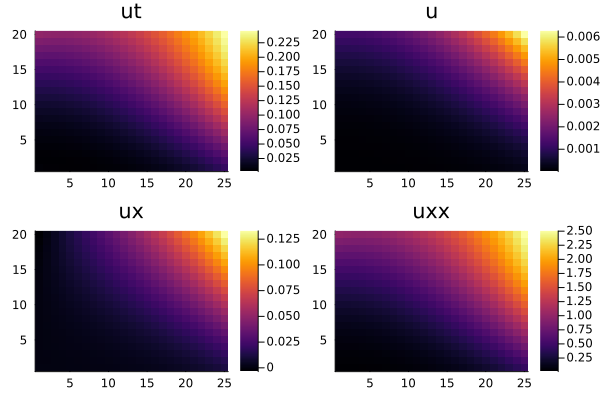

In [4]:
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g, order=4) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; order=4, boundary_condition="neumann") # takes BC and order as arguments
max_derivative_degree = 3
variables_matrix = GetVariablesMatrix(max_derivative_degree, data_array, g, ∂x)

# check accuracy of numerical derivatives
using Plots
# a,b = 1:size(data_array, 1),1:size(data_array, 2)
a,b = 1:20,1:25
p1 = heatmap(reshape(dt_data_array_flat ,(g.nt,g.nx))[a,b], title="ut")
p2 = heatmap(reshape(variables_matrix[1],(g.nt,g.nx))[a,b], title="u")
p3 = heatmap(reshape(variables_matrix[2],(g.nt,g.nx))[a,b], title="ux")
p4 = heatmap(reshape(variables_matrix[3],(g.nt,g.nx))[a,b], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))

In [5]:
# construct basis functions, eg: polynomial basis
max_poly_degree = 2
n_variables = max_derivative_degree + 1 # include 0th-derivative i.e. function itself
MyBasis = PolynomialBasis(max_poly_degree, n_variables, skip_constant = false)

# theta matrix
Θ = evaluate(MyBasis, variables_matrix)
# cond_number = norm(Θ,2) * norm(pinv(Θ),2)

37901×15 Matrix{Float64}:
 1.0  3.72665e-6    0.000186285   0.0089155  …    0.00394137      0.195436
 1.0  1.0405e-5    -5.567e-8      0.0280186       0.00133713      0.00227747
 1.0  1.65386e-5   -6.97142e-8    0.0383884       0.00126703      0.00108937
 1.0  2.55246e-5   -1.94703e-7    0.0519687       0.00169685      0.00106611
 1.0  3.76028e-5   -5.94436e-7    0.0693281       0.00229692      0.00109768
 1.0  5.35562e-5   -1.67709e-6    0.090759   …    0.00278841      0.000943913
 1.0  7.42341e-5   -4.27228e-6    0.116609        0.00257615      0.000488066
 1.0  0.000100554  -9.89596e-6    0.147211        0.000391316     7.06597e-6
 1.0  0.000133496  -2.10918e-5    0.182863       -0.006207        0.00115215
 1.0  0.000174098  -4.18368e-5    0.22382        -0.0215247       0.00924855
 ⋮                                           ⋱                 
 1.0  0.349006      0.0917561    -4.02409       143.05         1263.7
 1.0  0.347935      0.102835     -3.91685       142.638        1326.17

Perform sequential thresholded ridge regression at *fixed threshold* and *fixed* $\lambda$.

In [6]:
# perform ridge regression
STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-5, tol = 1e-1, iters = 4, verbose = true, normalize_columns = false)

Iteration: 4, threshold: 0.1. 
Iteration: 3, threshold: 0.1. 
Iteration: 2, threshold: 0.1. 
Iteration: 1, threshold: 0.1. 


Current fit: 
 $ \\ \partial_t u = \textcolor{grey}{\xi_{0000}} + \textcolor{grey}{\xi_{1000}u} + \textcolor{grey}{\xi_{0100}\partial_{x} u} + \xi_{0010}\partial_{xx} u + \textcolor{grey}{\xi_{0001}\partial_{xxx} u} + \textcolor{grey}{\xi_{2000}(u)^2} + \xi_{1100}u\partial_{x} u + \textcolor{grey}{\xi_{1010}u\partial_{xx} u} + \textcolor{grey}{\xi_{1001}u\partial_{xxx} u} + \textcolor{grey}{\xi_{0200}(\partial_{x} u)^2} + \textcolor{grey}{\xi_{0110}\partial_{x} u\partial_{xx} u} + \textcolor{grey}{\xi_{0101}\partial_{x} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0020}(\partial_{xx} u)^2} + \textcolor{grey}{\xi_{0011}\partial_{xx} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0002}(\partial_{xxx} u)^2} \\ $ with: $ \\\textcolor{grey}{\xi_{0000} = 0.0 \\ }\textcolor{grey}{\xi_{1000} = -0.03 \\ }\textcolor{grey}{\xi_{0100} = -0.0 \\ }\xi_{0010} = 0.1 \\ \textcolor{grey}{\xi_{0001} = -0.0 \\ }\textcolor{grey}{\xi_{2000} = 0.06 \\ }\xi_{1100} = -5.98 \\ \textcolor{grey}{\xi_{1010} = 0.01 \\ }\textcolor{grey}{\xi_{1001} = 0.0 \\ }\textcolor{grey}{\xi_{0200} = 0.0 \\ }\textcolor{grey}{\xi_{0110} = -0.0 \\ }\textcolor{grey}{\xi_{0101} = 0.0 \\ }\textcolor{grey}{\xi_{0020} = -0.0 \\ }\textcolor{grey}{\xi_{0011} = 0.0 \\ }\textcolor{grey}{\xi_{0002} = -0.0 \\ }$ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{0010} = 0.1 \\ \xi_{1100} = -5.99 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{0010} = 0.1 \\ \xi_{1100} = -5.99 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{0010} = 0.1 \\ \xi_{1100} = -5.99 \\ $ 
 - - -

([0.10307628893556717, -5.992286220344973], Any[[0, 0, 1, 0], [1, 1, 0, 0]])

The threshold landscape exploration. 

In [7]:
using LinearAlgebra, Plots
N = g.N
cond_number = cond(Θ, 2)

tol_range = 10.0 .^ (-5:1e-2:1.0)
L2_error²_array = zero(tol_range)
L0_error²_array = zero(tol_range)

for (i,tol) in enumerate(tol_range)
    ξ, active_poly_vectors = STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ=1e-5, tol=tol, iters=4)
    chosen_mask = MyBasis.poly_vectors .∈ Ref(active_poly_vectors)
    L2_error²_array[i] = norm(Θ[:, chosen_mask] * ξ - dt_data_array_flat, 2)^2
    L0_error²_array[i] = norm(ξ, 0)^2
end

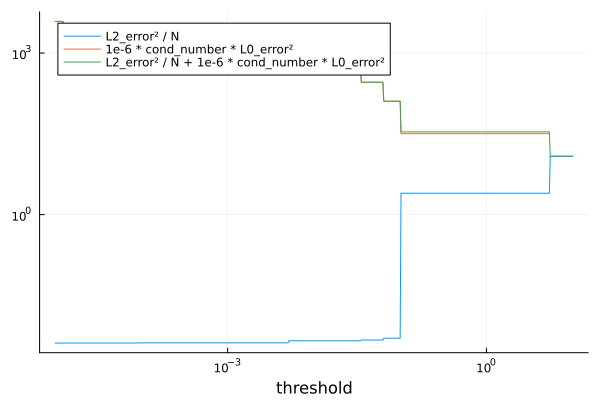

In [8]:
plot(tol_range, L2_error²_array ./ N, xscale=:log10, yscale=:log10, label="L2_error² / N", xlabel="threshold", legend=:topleft)
plot!(tol_range[L0_error²_array .> 0.], 1e-6 .* cond_number .* L0_error²_array[L0_error²_array .> 0.], label="1e-6 * cond_number * L0_error²")
plot!(tol_range, L2_error²_array ./ N + 1e-6 .* cond_number .* L0_error²_array, label="L2_error² / N + 1e-6 * cond_number * L0_error²")

Perform the choice of optimal threshold at *fixed* $\lambda$.

In [9]:
TrainSTRidge(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-5, tol_multiplier=1.0, iters = 5, verbose = true, cond_number_multiplier=1e-6,  max_tol_iters = 40)

Split input data to 30321 train and 7580 test samples. 
Using η = 1.0e-6 * 3.185851518765224e7. 
tol_iter = 1: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 3.60304160466944. 
tol_iter = 2: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 1.80152080233472. 
tol_iter = 3: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 0.90076040116736. 
tol_iter = 4: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 0.45038020058368. 
tol_iter = 5: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 0.22519010029184. 
tol_iter = 6: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 0.11259505014592. 
tol_iter = 7: Stepsize too big. Decreased tol_multi

([0.10354103573569635, -5.9955010075644255], Any[[0, 0, 1, 0], [1, 1, 0, 0]])

Investigate behaviour at different $\lambda$.

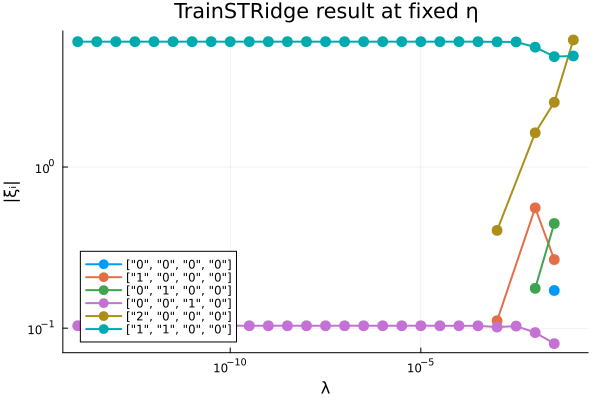

In [10]:
lambda_range = 10.0 .^ (-14.0:0.5:1.0)
to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5)

using Plots
plt = plot(legend=:bottomleft, xlabel="λ", ylabel="|ξᵢ|", title="TrainSTRidge result at fixed η")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end
display(plt)